# Alzheimer’s Disease Pathway — Min-Cut Pipeline

What this notebook does

- 1. Fetch KEGG hsa05010 (Alzheimer’s disease) genes via KEGG REST API
- 2. Map to gene symbols; query STRING API for PPI network (human 9606)
- 3. Build a weighted NetworkX graph
- 4. Compute:
  - Global min-cut (Stoer–Wagner, weighted)
  - s–t min edge cut (sources: APP/PSEN1/PSEN2/MAPT; sinks: CASP3/CASP8/APAF1)
  - Karger randomized min-cut on unweighted graph (10/100/1000 trials)

5.  Visualize network snapshot (cut edges) and a trials-vs-average plot


In [2]:
%pip install requests

import io
import sys
import math
import time
from collections import defaultdict

import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

print(sys.version)
print("NetworkX:", nx.__version__)

Note: you may need to restart the kernel to use updated packages.
3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
NetworkX: 3.4.2


In [3]:
KEGG_BASE = "http://rest.kegg.jp"
KEGG_PATHWAY_ID = "hsa05010"  # Alzheimer's disease

def kegg_link_hsa(pathway_id: str) -> pd.DataFrame:
    """
    KEGG: link hsa <pathway> → pathway-to-gene rows: path:hsa05010 \t hsa:351
    """
    url = f"{KEGG_BASE}/link/hsa/{pathway_id}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    rows = [line.split("\t") for line in r.text.strip().splitlines()]
    df = pd.DataFrame(rows, columns=["pathway", "hsa_id"])
    return df

def kegg_get_gene_symbols(hsa_ids: list) -> pd.DataFrame:
    """
    KEGG: get hsa:XXXX blocks; parse NAME line for the primary gene symbol.
    """
    chunks = []
    BATCH = 50
    for i in range(0, len(hsa_ids), BATCH):
        batch = hsa_ids[i:i+BATCH]
        ids_str = "+".join(batch)
        url = f"{KEGG_BASE}/get/{ids_str}"
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        # Split into entries using 'ENTRY' as delimiter
        entries = r.text.split("ENTRY")
        for ent in entries:
            if not ent.strip():
                continue
            # Try to find an 'hsa:' token in the block (gene id)
            tokens = [t for t in ent.split() if t.startswith("hsa:")]
            hsa_id = tokens[0] if tokens else None

            # Parse NAME line: e.g., "NAME        APP; amyloid beta precursor protein"
            symbol = None
            for ln in ent.splitlines():
                if ln.strip().startswith("NAME"):
                    rest = ln.split("NAME", 1)[1].strip()
                    if ";" in rest:
                        symbol = rest.split(";")[0].strip()
                    else:
                        symbol = rest.split(",")[0].strip()
                    break
            if hsa_id and symbol:
                chunks.append((hsa_id, symbol))
    return pd.DataFrame(chunks, columns=["hsa_id", "gene_symbol"])

# Fetch KEGG genes
link_df = kegg_link_hsa(KEGG_PATHWAY_ID)
hsa_ids = sorted(link_df["hsa_id"].unique().tolist())
genes_df = kegg_get_gene_symbols(hsa_ids)
print("Pathway:", KEGG_PATHWAY_ID, "| genes:", len(genes_df))
display(genes_df.head())


Pathway: hsa05010 | genes: 0


,hsa_id,gene_symbol


In [5]:
import requests
import pandas as pd
import io

# STRING API settings
STRING_BASE = "https://string-db.org/api"
STRING_FORMAT = "tsv"
STRING_METHOD = "network"
SPECIES = 9606  # 9606 = human
SCORE_CUTOFF = 700  # high confidence (0..1000)


def string_network_from_genes(genes: list, species: int = 9606, score_cutoff: int = 700) -> pd.DataFrame:
    """
    Query STRING 'tsv/network' API with a list of gene identifiers.
    Returns DataFrame with columns: preferredName_A, preferredName_B, score, etc.
    """
    identifiers = "%0d".join(genes)  # join with carriage return encoding
    url = f"{STRING_BASE}/{STRING_FORMAT}/{STRING_METHOD}?identifiers={identifiers}&species={species}&required_score={score_cutoff}"
    
    r = requests.get(url, timeout=90)
    r.raise_for_status()
    
    df = pd.read_csv(io.StringIO(r.text), sep="\t")
    return df


# Example: manually provide gene list
gene_list = ["TP53", "BRCA1", "EGFR", "MYC", "AKT1"]

# Fetch interactions
str_df = string_network_from_genes(gene_list, species=SPECIES, score_cutoff=SCORE_CUTOFF)

print(f"STRING edges (score ≥ {SCORE_CUTOFF}):", len(str_df))
print(str_df.head())


STRING edges (score ≥ 700): 10
             stringId_A            stringId_B preferredName_A preferredName_B  \
0  9606.ENSP00000269305  9606.ENSP00000275493            TP53            EGFR   
1  9606.ENSP00000269305  9606.ENSP00000451828            TP53            AKT1   
2  9606.ENSP00000269305  9606.ENSP00000478887            TP53             MYC   
3  9606.ENSP00000269305  9606.ENSP00000418960            TP53           BRCA1   
4  9606.ENSP00000275493  9606.ENSP00000451828            EGFR            AKT1   

   ncbiTaxonId  score  nscore  fscore  pscore  ascore  escore  dscore  tscore  
0         9606  0.943       0       0       0   0.000   0.329     0.0   0.919  
1         9606  0.994       0       0       0   0.049   0.184     0.9   0.934  
2         9606  0.997       0       0       0   0.067   0.300     0.0   0.997  
3         9606  0.999       0       0       0   0.067   0.895     0.5   0.999  
4         9606  0.792       0       0       0   0.042   0.640     0.0   0.445  


In [7]:
def build_graph_from_string(df: pd.DataFrame, allowed_nodes: set) -> nx.Graph:
    """
    Build undirected weighted graph from STRING network table.
    Uses preferredName_A/B (or protein1/protein2 fallback) and score as weight.
    """
    G = nx.Graph()
    for _, row in df.iterrows():
        a = row.get("preferredName_A") or row.get("protein1")
        b = row.get("preferredName_B") or row.get("protein2")
        if not a or not b:
            continue
        if a not in allowed_nodes or b not in allowed_nodes:
            continue
        w = int(row.get("score") or row.get("combined_score") or 0)
        if G.has_edge(a, b):
            # keep max weight if duplicates appear
            if w > G[a][b].get("weight", 0):
                G[a][b]["weight"] = w
        else:
            G.add_edge(a, b, weight=w)
    return G

allowed = set(gene_list)
G = build_graph_from_string(str_df, allowed)
print("Nodes:", G.number_of_nodes(), "| Edges:", G.number_of_edges())

# Basic sanity: connected components
comps = sorted(nx.connected_components(G), key=len, reverse=True)
print("Connected components:", len(comps), "| largest size:", len(comps[0]) if comps else 0)


Nodes: 5 | Edges: 10
Connected components: 1 | largest size: 5


In [10]:
from networkx.algorithms.connectivity import stoer_wagner, minimum_edge_cut

def cut_edges_from_partition(G: nx.Graph, partition):
    A, B = map(set, partition)
    return [(u, v, G[u][v].get("weight", 1))
            for (u, v) in G.edges()
            if (u in A and v in B) or (u in B and v in A)]

# 5a) Global min-cut
if G.number_of_nodes() > 1 and G.number_of_edges() > 0:
    sw_value, sw_part = stoer_wagner(G, weight="weight")
    sw_edges = cut_edges_from_partition(G, sw_part)
    print("Global min-cut value (weighted):", sw_value, "| edges in cut:", len(sw_edges))
else:
    sw_value, sw_part, sw_edges = None, (set(), set()), []
    print("Graph too small for global min-cut.")

# 5b) s–t min edge cut between selected biological sets
sources = [g for g in ["APP", "PSEN1", "PSEN2", "MAPT"] if g in G]
sinks   = [g for g in ["CASP3", "CASP8", "APAF1"] if g in G]

def st_edge_cut_multi_source_sink(G: nx.Graph, sources, sinks):
    """
    Try all (s, t) pairs and choose the smallest minimum_edge_cut (by edge count).
    For small sets this is fine. Returns best pair and edge set.
    """
    best = None
    best_pair = None
    for s in sources:
        for t in sinks:
            if s == t:
                continue
            cut = minimum_edge_cut(G, s, t)  # edge set
            if best is None or len(cut) < len(best):
                best = cut
                best_pair = (s, t)
    return best_pair, best or set()

st_pair, st_cut = (None, None), set()
if sources and sinks:
    st_pair, st_cut = st_edge_cut_multi_source_sink(G, sources, sinks)
    print("Best s–t pair:", st_pair, "| s–t cut size (edges):", len(st_cut))
else:
    print("Note: some source/sink genes absent → s–t cut may be empty.")


Global min-cut value (weighted): 0 | edges in cut: 4
Note: some source/sink genes absent → s–t cut may be empty.


In [11]:
import random

def karger_min_cut_unweighted(G: nx.Graph, rng: random.Random):
    """
    Classic Karger random contraction algorithm (unweighted).
    We keep 'multiplicity' on edges formed by contraction to count parallel edges.
    """
    H = G.copy()
    H.remove_edges_from(nx.selfloop_edges(H))
    # Initialize multiplicity = 1 for all edges
    for u, v in H.edges():
        if "multiplicity" not in H[u][v]:
            H[u][v]["multiplicity"] = 1

    while H.number_of_nodes() > 2:
        u, v = rng.choice(list(H.edges()))
        # Contract v into u
        for nbr in list(H.neighbors(v)):
            if nbr == u:
                continue
            mult = H[v][nbr].get("multiplicity", 1)
            if H.has_edge(u, nbr):
                H[u][nbr]["multiplicity"] = H[u][nbr].get("multiplicity", 1) + mult
            else:
                H.add_edge(u, nbr, multiplicity=mult)
        H.remove_node(v)
        if H.has_edge(u, u):
            H.remove_edge(u, u)

    cut_size = sum(data.get("multiplicity", 1) for _, _, data in H.edges(data=True))
    return cut_size

def run_karger_trials(G: nx.Graph, trials: int, seed: int = 42):
    rng = random.Random(seed)
    # Use an unweighted copy (ignore 'weight' when contracting)
    U = nx.Graph()
    U.add_nodes_from(G.nodes())
    U.add_edges_from(G.edges())  # no weights
    vals = []
    for _ in range(trials):
        vals.append(karger_min_cut_unweighted(U, rng))
    return vals

trial_list = [10, 100, 1000]
karger_results = {t: run_karger_trials(G, t, seed=123) for t in trial_list}
pd.DataFrame({t: pd.Series(v) for t, v in karger_results.items()}).describe()


,10,100,1000
count,10.000000,100.0,1000.000000
mean,4.800000,4.9,5.018000
std,1.032796,1.0,1.000338
min,4.000000,4.0,4.000000
25%,4.000000,4.0,4.000000
50%,4.000000,4.0,6.000000
75%,6.000000,6.0,6.000000
max,6.000000,6.0,6.000000


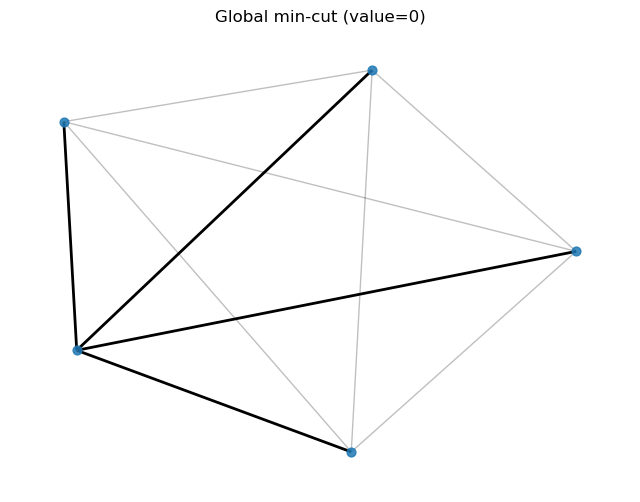

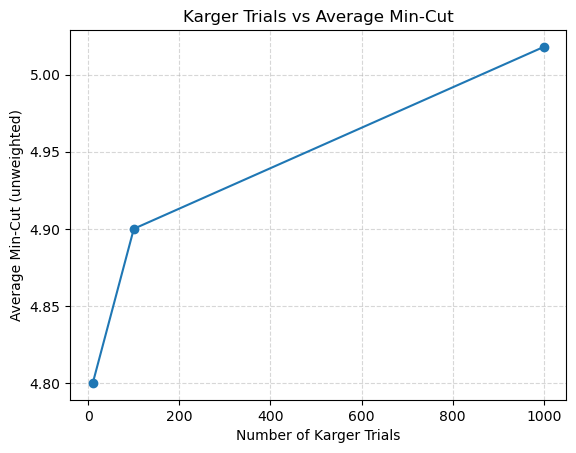

In [12]:
# 7.1 Global min-cut snapshot (if graph is not too big)
def draw_cut_snapshot(G: nx.Graph, partition, title: str):
    if G.number_of_nodes() > 400:
        print("Graph too large for a clear static plot; skipping snapshot.")
        return
    pos = nx.spring_layout(G, seed=7)
    A, B = map(set, partition)
    cut_edges = [(u, v) for (u, v) in G.edges()
                 if (u in A and v in B) or (u in B and v in A)]
    non_cut = [(u, v) for (u, v) in G.edges() if (u, v) not in cut_edges]

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_size=40, alpha=0.85)
    nx.draw_networkx_edges(G, pos, edgelist=non_cut, alpha=0.25)
    # Emphasize cut edges
    nx.draw_networkx_edges(G, pos, edgelist=cut_edges, width=2)
    plt.title(title)
    plt.axis("off")
    plt.show()

if isinstance(sw_part, tuple) and sw_value is not None:
    draw_cut_snapshot(G, sw_part, f"Global min-cut (value={sw_value})")

# 7.2 s–t cut snapshot (if available)
if st_cut:
    Htmp = G.copy()
    Htmp.remove_edges_from(list(st_cut))
    comps = list(nx.connected_components(Htmp))
    A = set()
    for c in comps:
        if any(s in c for s in sources):
            A.update(c)
    B = set(G.nodes()) - A
    draw_cut_snapshot(G, (A, B), f"s–t min edge cut | pair={st_pair} | size={len(st_cut)}")

# 7.3 Karger summary plot — trials vs average cut size
trial_counts = sorted(karger_results.keys())
means = [pd.Series(karger_results[t]).mean() for t in trial_counts]
plt.figure()
plt.plot(trial_counts, means, marker='o')
plt.xlabel("Number of Karger Trials")
plt.ylabel("Average Min-Cut (unweighted)")
plt.title("Karger Trials vs Average Min-Cut")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [13]:
# Global min-cut edges (weighted)
if sw_value is not None:
    sw_edges_tbl = pd.DataFrame(sw_edges, columns=["u", "v", "weight"]).sort_values("weight", ascending=False)
    display(sw_edges_tbl.head(20))
else:
    sw_edges_tbl = pd.DataFrame()
    print("No global min-cut edges table (graph too small).")

# s–t cut edges (weighted lookups)
if st_cut:
    st_edges_tbl = pd.DataFrame([(u, v, G[u][v].get("weight", 1)) for (u, v) in st_cut],
                                columns=["u", "v", "weight"]).sort_values("weight", ascending=False)
    display(st_edges_tbl.head(20))
else:
    print("No s–t cut edges found or sources/sinks missing.")

# Centrality around global cut edges
if not sw_edges_tbl.empty:
    cut_nodes = set(sw_edges_tbl["u"]).union(set(sw_edges_tbl["v"]))
    sub_nodes = set(cut_nodes)
    for n in list(cut_nodes):
        sub_nodes.update(G.neighbors(n))
    Hsub = G.subgraph(sub_nodes).copy()

    bet = nx.betweenness_centrality(Hsub, normalized=True)
    deg = dict(Hsub.degree())

    cen_tbl = pd.DataFrame({
        "node": list(Hsub.nodes()),
        "degree": [deg[n] for n in Hsub.nodes()],
        "betweenness": [bet.get(n, 0.0) for n in Hsub.nodes()],
        "is_cut_node": [n in cut_nodes for n in Hsub.nodes()]
    }).sort_values(["is_cut_node", "betweenness", "degree"], ascending=[False, False, False])

    display(cen_tbl.head(30))
else:
    print("Centrality skipped: no global min-cut edges.")


,u,v,weight
0,TP53,BRCA1,0
1,EGFR,BRCA1,0
2,AKT1,BRCA1,0
3,MYC,BRCA1,0


No s–t cut edges found or sources/sinks missing.


,node,degree,betweenness,is_cut_node
0,TP53,4,0.0,True
1,EGFR,4,0.0,True
2,AKT1,4,0.0,True
3,MYC,4,0.0,True
4,BRCA1,4,0.0,True
